In [ ]:
!pip install pycaret
!pip install jinja2
!pip install markupsafe==2.0.1
!pip install shap

In [ ]:
# Import important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.preprocessing as pre
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sns
from pandas.core.arrays.categorical import contains
from pycaret.utils import version
from pycaret.classification import *
import pandas_profiling
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
import jinja2
import re
%matplotlib inline
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score


Saving train.csv to train (7).csv


In [ ]:
# Importing Data to Google Colab
from google.colab import files
uploaded = files.upload()
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
#test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
#sub = pd.read_csv(io.BytesIO(uploaded['gender_submission.csv']))

# Exploratory Data Analysis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
profile = ProfileReport(train, title="Space Titanic Dataset", html={'style': {'full_width': True}}, sort=None)

In [ ]:
profile.to_notebook_iframe()

In [ ]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Feature Engineering

### Spliting out the PassengerId into PassengerId and MemberId

In [ ]:
train[['PassengerId','MemberId']] = train['PassengerId'].str.split('_', n=2, expand = True)

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,MemberId
0,0001,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,01
1,0002,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,01
2,0003,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,01
3,0003,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,02
4,0004,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,01


### HomePlanet NA fill in

In [ ]:
train.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [ ]:
train.HomePlanet.isna().sum()

201

In [ ]:
train['HomePlanet'].fillna("Other", inplace = True)

In [ ]:
train.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', 'Other'], dtype=object)

### CryoSleep NA fill in

In [ ]:
train.CryoSleep.unique()

array([False, True, nan], dtype=object)

In [ ]:
train.CryoSleep.isna().sum()

217

In [ ]:
train['CryoSleep'].fillna("Other", inplace = True)

In [ ]:
train.CryoSleep.unique()

array([False, True, 'Other'], dtype=object)

### Cabin Features take first letter of the cabin and create new column

In [ ]:
train['Cabinarea'] = train['Cabin'].astype(str).str[0]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  MemberId      8693 non-null   object 
 15  Cabinarea     8693 non-null   object 
dtypes: bool(1), float64(6), object(9)
memory usage: 1.0+ MB


### Add new feature Total Spent

In [ ]:
train['Totalspent'] = train['RoomService'] + train['FoodCourt'] + train['Spa'] + train['VRDeck']

In [ ]:
train.Totalspent.isna().sum()

906

In [ ]:
train['Totalspent'].fillna(0, inplace = True)

turn it into categorical variables

In [ ]:
train.loc[train['Totalspent'] <= 0, 'Totalspent'] = 0
train.loc[(train['Totalspent'] > 1) & (train['Totalspent'] <= 1000), 'Totalspent'] = 1
train.loc[(train['Totalspent'] > 1000) & (train['Totalspent'] <= 2000), 'Totalspent'] = 2
train.loc[(train['Totalspent'] > 2000) & (train['Totalspent'] <= 6000), 'Totalspent'] = 3
train.loc[(train['Totalspent'] > 6000) & (train['Totalspent'] <= 8000), 'Totalspent'] = 4
train.loc[train['Totalspent'] > 8000, 'Totalspent'] = 5;

In [ ]:
train['RoomService'].fillna(0, inplace = True)

In [ ]:
train.loc[train['RoomService'] <= 0, 'VIP'] = 0
train.loc[(train['RoomService'] > 1) & (train['RoomService'] <= 1000), 'RoomService'] = 1
train.loc[(train['RoomService'] > 1000) & (train['RoomService'] <= 2000), 'RoomService'] = 2
train.loc[(train['RoomService'] > 2000) & (train['RoomService'] <= 6000), 'RoomService'] = 3
train.loc[(train['RoomService'] > 6000) & (train['RoomService'] <= 8000), 'RoomService'] = 4
train.loc[train['RoomService'] > 8000, 'RoomService'] = 5;

### Age to split in categorical factor

In [ ]:
train['Age'].fillna(train['Age'].mean())

0       39.0
1       24.0
2       58.0
3       33.0
4       16.0
        ... 
8688    41.0
8689    18.0
8690    26.0
8691    32.0
8692    44.0
Name: Age, Length: 8693, dtype: float64

In [ ]:
train.loc[train['Age'] <= 10, 'Age'] = 0
train.loc[(train['Age'] > 10) & (train['Age'] <= 18), 'Age'] = 1
train.loc[(train['Age'] > 18) & (train['Age'] <= 32), 'Age'] = 2
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age'] = 3
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age'] = 4
train.loc[train['Age'] > 64, 'Age'];


### VIP changes 1 and 0

In [ ]:
train.VIP.unique()

array([False, True, nan], dtype=object)

In [ ]:
train['VIP'].fillna(False, inplace = True)

In [ ]:
train.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination     182
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
MemberId          0
Cabinarea         0
Totalspent        0
dtype: int64

### if they have a Cabin or not

In [ ]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [ ]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,MemberId,Cabinarea,Totalspent,Has_Cabin
0,0001,Europa,False,B/0/P,TRAPPIST-1e,3.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,01,B,0.0,1
1,0002,Earth,False,F/0/S,TRAPPIST-1e,2.0,False,1.0,9.0,25.0,549.0,44.0,Juanna Vines,True,01,F,1.0,1
2,0003,Europa,False,A/0/S,TRAPPIST-1e,4.0,True,1.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,01,A,5.0,1
3,0003,Europa,False,A/0/S,TRAPPIST-1e,3.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,02,A,3.0,1
4,0004,Earth,False,F/1/S,TRAPPIST-1e,1.0,False,1.0,70.0,151.0,565.0,2.0,Willy Santantines,True,01,F,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,Europa,False,A/98/P,55 Cancri e,3.0,0,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,01,A,5.0,1
8689,9278,Earth,True,G/1499/S,PSO J318.5-22,1.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,01,G,0.0,1
8690,9279,Earth,False,G/1500/S,TRAPPIST-1e,2.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,01,G,1.0,1
8691,9280,Europa,False,E/608/S,55 Cancri e,2.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,01,E,3.0,1


In [ ]:
clean_train = train.drop(['Name','FoodCourt','ShoppingMall','Spa','VRDeck','Cabin','PassengerId'], axis = 1)

In [ ]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HomePlanet   8693 non-null   object 
 1   CryoSleep    8693 non-null   object 
 2   Destination  8511 non-null   object 
 3   Age          8514 non-null   float64
 4   VIP          8693 non-null   object 
 5   RoomService  8693 non-null   float64
 6   Transported  8693 non-null   bool   
 7   MemberId     8693 non-null   object 
 8   Cabinarea    8693 non-null   object 
 9   Totalspent   8693 non-null   float64
 10  Has_Cabin    8693 non-null   int64  
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 687.8+ KB


# Testing PyCaret Models

In [ ]:
experiment = setup(data = clean_train, 
             target = 'Transported',
             numeric_imputation = 'mean',
             categorical_features = ['CryoSleep','Destination','Age','VIP','MemberId','Has_Cabin','Totalspent','Cabinarea','HomePlanet','RoomService'], 
             silent = True,
            remove_outliers = True,
            normalize = True, transformation = True, feature_interaction= True, train_size = .8, log_experiment = True, feature_selection = True)

,Description,Value
0,session_id,681
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(8693, 11)"
5,Missing Values,True
6,Numeric Features,0
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


2022/06/03 16:21:49 INFO mlflow.tracking.fluent: Experiment with name 'clf-default-name' does not exist. Creating a new experiment.


In [ ]:
 #show the best model and their statistics
 best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7356,0.8067,0.6645,0.7805,0.7175,0.4721,0.4778,0.796
ridge,Ridge Classifier,0.7328,0.0000,0.6669,0.7740,0.7161,0.4663,0.4713,0.033
lda,Linear Discriminant Analysis,0.7328,0.8005,0.6666,0.7742,0.7160,0.4663,0.4713,0.109
lr,Logistic Regression,0.7321,0.8012,0.6654,0.7737,0.7151,0.4651,0.4701,0.225
ada,Ada Boost Classifier,0.7315,0.8007,0.6755,0.7668,0.7177,0.4638,0.4677,0.318
lightgbm,Light Gradient Boosting Machine,0.7311,0.7982,0.6717,0.7678,0.7161,0.4629,0.4670,0.150
nb,Naive Bayes,0.7261,0.7851,0.6325,0.7846,0.7001,0.4534,0.4625,0.035
svm,SVM - Linear Kernel,0.7217,0.0000,0.6837,0.7501,0.7122,0.4439,0.4493,0.116
rf,Random Forest Classifier,0.7140,0.7811,0.6791,0.7356,0.7059,0.4285,0.4301,0.888
et,Extra Trees Classifier,0.7099,0.7670,0.6630,0.7373,0.6979,0.4205,0.4229,0.926


In [ ]:
model2 = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7504,0.8286,0.7432,0.7546,0.7489,0.5008,0.5008
1,0.7413,0.8062,0.6918,0.7685,0.7281,0.4827,0.4851
2,0.7231,0.8005,0.7069,0.7312,0.7189,0.4463,0.4466
3,0.7443,0.8238,0.7553,0.7396,0.7474,0.4886,0.4887
4,0.7610,0.8392,0.7492,0.7678,0.7584,0.5220,0.5221
5,0.7640,0.8421,0.7402,0.7778,0.7585,0.5280,0.5286
6,0.7409,0.8247,0.6970,0.7641,0.7290,0.4818,0.4837
7,0.7455,0.8126,0.7281,0.7555,0.7415,0.4910,0.4913
8,0.7667,0.8550,0.7130,0.8000,0.7540,0.5335,0.5367


In [ ]:
tuned_model1 = tune_model(model2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7504,0.8200,0.7190,0.7677,0.7426,0.5008,0.5018
1,0.7413,0.8003,0.6767,0.7778,0.7237,0.4827,0.4868
2,0.7141,0.7963,0.7039,0.7191,0.7115,0.4282,0.4283
3,0.7489,0.8172,0.7553,0.7463,0.7508,0.4977,0.4978
4,0.7625,0.8442,0.7613,0.7636,0.7625,0.5250,0.5250
5,0.7610,0.8351,0.7281,0.7799,0.7531,0.5220,0.5231
6,0.7439,0.8263,0.6909,0.7729,0.7296,0.4879,0.4906
7,0.7470,0.8070,0.7190,0.7628,0.7403,0.4940,0.4948
8,0.7742,0.8563,0.7160,0.8116,0.7608,0.5486,0.5525


In [ ]:
#evaluate model
evaluate_model(tuned_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

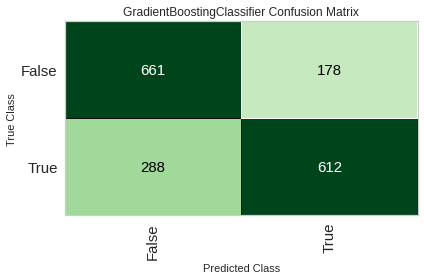

In [ ]:
plot_model(estimator = tuned_model1, plot = 'confusion_matrix')

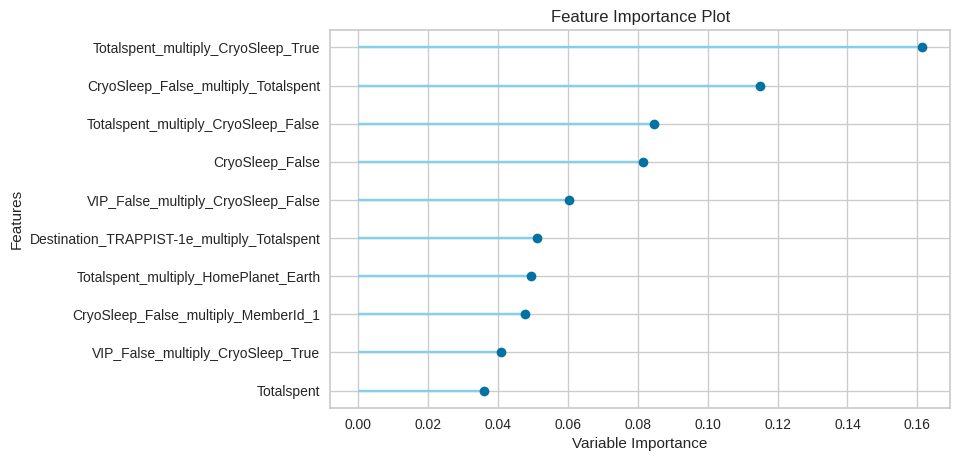

In [ ]:
plot_model(estimator = tuned_model1, plot = 'feature')